In [59]:
import sqlite3
import os
import sys
sys.path.append('..')  # Add parent directory to the Python path
from utils.helpers import *

In [60]:
def compute_embeddings_mean(document_embeddings):
    sum_array = np.sum(document_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(document_embeddings))
    return mean_array

def compute_all_embeddings_mean(document_tokens, embeddings_dim):
    document_embeddings = []
    
    for token in document_tokens:
        word = token['word']
        if word in embeddings:
            document_embeddings.append(embeddings[word])
    
    if len(document_embeddings) == 0:
        mean_document_embeddings = np.zeros(embeddings_dim)
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings

def compute_filtered_embeddings_mean(document_tokens, embeddings_dim):
    document_embeddings = []
    
    for token in document_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB']:
            document_embeddings.append(embeddings[word])
    
    if len(document_embeddings) == 0:
        mean_document_embeddings = np.zeros(embeddings_dim)
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings


def compute_filtered_embeddings_sep_means(document_tokens, embeddings_dim):
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    
    for token in document_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ']:
            adj_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['NOUN']:
            noun_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['VERB']:
            verb_embeddings.append(embeddings[word])
    
    if len(adj_embeddings) == 0:
        mean_adj_embeddings = np.zeros(embeddings_dim)
    else:
        mean_adj_embeddings = compute_embeddings_mean(adj_embeddings)
        
    if len(noun_embeddings) == 0:
        mean_noun_embeddings = np.zeros(embeddings_dim)
    else:
        mean_noun_embeddings = compute_embeddings_mean(noun_embeddings)
        
    if len(verb_embeddings) == 0:
        mean_verb_embeddings = np.zeros(embeddings_dim)
    else:
        mean_verb_embeddings = compute_embeddings_mean(verb_embeddings)
    
    
    mean_document_embeddings = np.concatenate([mean_adj_embeddings, mean_noun_embeddings, mean_verb_embeddings], axis=None)
    return mean_document_embeddings

In [61]:
def extract_features(documents, embeddings_dim, pos=False):
    dataset_features = []
    for document_tokens in documents:
        if not pos:
            document_embeddings = compute_all_embeddings_mean(document_tokens, embeddings_dim)
        else:
        #document_embeddings = compute_filtered_embeddings_mean(document_tokens, embeddings_dim)
            document_embeddings = compute_filtered_embeddings_sep_means(document_tokens, embeddings_dim)
        dataset_features.append(document_embeddings)
    return dataset_features

In [62]:
def train_test_split(all_features, all_labels, all_documents_paths):
    train_features, train_labels = [], []
    test_features, test_labels = [], []
    
    for features, label,  document_path in zip(all_features, all_labels, all_documents_paths):
        if 'training' in document_path:
            train_features.append(features)
            train_labels.append(label)
        else:
            test_features.append(features)
            test_labels.append(label)
    return train_features, train_labels, test_features, test_labels


In [63]:
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Configurazioni da esplorare
embedding_dim = [32, 64, 128]  # Dimensioni degli embedding
representations = [False, True]  # False = solo "word", True = "word + pos"

# Directory e path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
dir_name = 'itwac'
conllu_dir = 'data/profiling_output/11462'
results = []

# Parametri della GridSearch
param_grid = {
    'C': [10, 1, 0.1, 0.01, 0.001],
    'dual': [True, False]
}

# Aggiungi le modalità di estrazione
feature_modes = ["all_mean", "sep_means", "filtered"]

for dim in embedding_dim:
    embeddings_path = f'{dir_name}/itwac{dim}.txt'
    all_documents_paths = []
    for file_name in os.listdir(conllu_dir):
        file_path = os.path.join(conllu_dir, file_name)
        all_documents_paths.append(file_path)
    embeddings = load_word_embeddings(parent_dir+"/"+embeddings_path)
    
    for postg in representations:
        representation_type = "word + pos" if postg else "word"
        print()
        print(f"Modello: Embedding Dim={dim} di {representation_type}")
        
        all_documents = []
        for document_path in all_documents_paths:
            document_tokens = get_tokens_from_file(document_path, postg=postg)
            all_documents.append(document_tokens)

        # Itera sulle modalità di estrazione se è "word+pos"
        if postg:
            for mode in feature_modes:
                print(f"Modalità di estrazione: {mode}")
                
                if mode == "all_mean":
                    all_features = [compute_all_embeddings_mean(doc, dim) for doc in all_documents]
                elif mode == "sep_means":
                    all_features = [compute_filtered_embeddings_sep_means(doc, dim) for doc in all_documents]
                elif mode == "filtered":
                    all_features = [compute_filtered_embeddings_mean(doc, dim) for doc in all_documents]
                
                all_labels = create_label_list(all_documents_paths)
                train_features, train_labels, test_features, test_labels = train_test_split(
                    all_features, all_labels, all_documents_paths)
                # Feature extraction e scaling
                scaler = MinMaxScaler()
                X_train = scaler.fit_transform(train_features)

                # GridSearch con SVM lineare
                svc = LinearSVC()
                grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, refit=True)
                grid_search.fit(X_train, train_labels)

                # Calcola metriche su train e test
                X_test = scaler.transform(test_features)
                predictions = grid_search.best_estimator_.predict(X_test)
                val_acc = grid_search.best_score_  # Media delle validation accuracy nei fold
                test_acc = np.mean(predictions == test_labels)  # Test accuracy

                # Salva il risultato
                results.append({
                    "embedding_dim": dim,
                    "representation": representation_type,
                    "mode": mode,
                    "val_acc": val_acc,
                    "test_predictions": predictions,
                    "test_acc": test_acc,
                    "test_labels": test_labels,
                    "best_params": grid_search.best_params_
                })

                print("Validation accuracy", val_acc)
        else:
            # Solo una modalità per "word"
            all_features = [compute_all_embeddings_mean(doc, dim) for doc in all_documents]
            all_labels = create_label_list(all_documents_paths)
            train_features, train_labels, test_features, test_labels = train_test_split(
                all_features, all_labels, all_documents_paths)
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(train_features)

            # GridSearch con SVM lineare
            svc = LinearSVC()
            grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, refit=True)
            grid_search.fit(X_train, train_labels)

            # Calcola metriche su train e test
            X_test = scaler.transform(test_features)
            predictions = grid_search.best_estimator_.predict(X_test)
            val_acc = grid_search.best_score_  # Media delle validation accuracy nei fold
            test_acc = np.mean(predictions == test_labels)  # Test accuracy

            # Salva il risultato
            results.append({
                "embedding_dim": dim,
                "representation": representation_type,
                "mode": "all_mean",  # Default per "word"
                "val_acc": val_acc,
                "test_predictions": predictions,
                "test_acc": test_acc,
                "test_labels": test_labels,
                "best_params": grid_search.best_params_
            })

            print("Validation accuracy", val_acc)


# Trova i modelli migliori per validation accuracy
best_val_model = max(results, key=lambda x: x["val_acc"])

# Confusion matrix e classification report per il miglior modello di validazione
best_dim = best_val_model["embedding_dim"]
best_mode = best_val_model["mode"]


Modello: Embedding Dim=32 di word


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation accuracy 0.5865756541524461

Modello: Embedding Dim=32 di word + pos
Modalità di estrazione: all_mean


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation accuracy 0.5865756541524461
Modalità di estrazione: sep_means


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number 

Validation accuracy 0.5667804323094426
Modalità di estrazione: filtered


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation accuracy 0.5731513083048919

Modello: Embedding Dim=64 di word


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation accuracy 0.5888509670079636

Modello: Embedding Dim=64 di word + pos
Modalità di estrazione: all_mean


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation accuracy 0.5888509670079636
Modalità di estrazione: sep_means


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number 

Validation accuracy 0.5681456200227532
Modalità di estrazione: filtered


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation accuracy 0.5717861205915813

Modello: Embedding Dim=128 di word


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number 

Validation accuracy 0.5961319681456201

Modello: Embedding Dim=128 di word + pos
Modalità di estrazione: all_mean


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number 

Validation accuracy 0.5961319681456201
Modalità di estrazione: sep_means


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number 

Validation accuracy 0.571103526734926
Modalità di estrazione: filtered


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number 

Validation accuracy 0.563367463026166


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 Best model basato sulla Validation Accuracy:

 Best params: {'C': 0.1, 'dual': True}
Dimensione Embedding: 128, utilizzando: word
Modalità di combinazione embs: all_mean
Validation Accuracy: 0.5961319681456201
Test Accuracy: 0.5372727272727272

Classification Report:
              precision    recall  f1-score   support

           F       0.53      0.76      0.62      2200
           M       0.57      0.31      0.40      2200

    accuracy                           0.54      4400
   macro avg       0.55      0.54      0.51      4400
weighted avg       0.55      0.54      0.51      4400

Confusion Matrix:


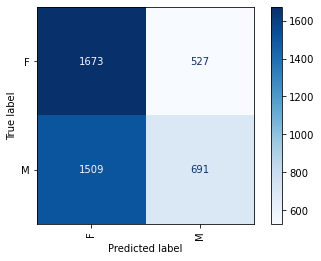

In [64]:
import matplotlib.pyplot as plt

# Trova il modello migliore per validation accuracy
best_val_model = max(results, key=lambda x: x["val_acc"])

# Estrai i dettagli del modello migliore
best_dim = best_val_model["embedding_dim"]
best_rep = best_val_model["representation"]
best_test_predictions = best_val_model["test_predictions"]
best_test_labels = best_val_model["test_labels"]

print("\n Best model basato sulla Validation Accuracy:")
print(f"\n Best params: {best_val_model['best_params']}")
print(f"Dimensione Embedding: {best_dim}, utilizzando: {best_rep}")
print(f"Modalità di combinazione embs: {best_mode}")
print("Validation Accuracy:", best_val_model["val_acc"])
print("Test Accuracy:", best_val_model["test_acc"])

# Confusion Matrix e Classification Report per il modello migliore
print("\nClassification Report:")
print(classification_report(best_test_labels, best_test_predictions, zero_division=0))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(
    best_test_labels,
    best_test_predictions,
    xticks_rotation="vertical",
    cmap="Blues"
)
plt.show()

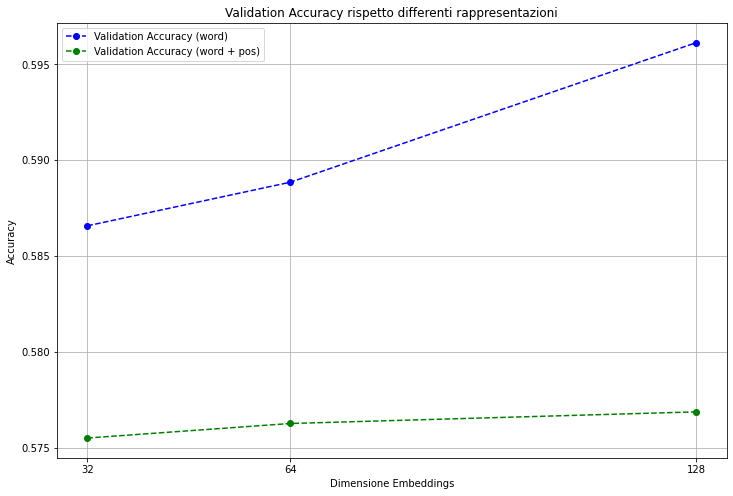

In [65]:
# Trova i risultati per ogni rappresentazione
val_accuracies = {"word": [], "word + pos": []}
test_accuracies = {"word": [], "word + pos": []}
embs_sizes = sorted(list(set(result["embedding_dim"] for result in results)))

# Calcola la media delle accuratezze per ciascuna dimensione di embedding
for rep in ["word", "word + pos"]:
    val_acc_per_dim = {dim: [] for dim in embs_sizes}
    test_acc_per_dim = {dim: [] for dim in embs_sizes}
    
    for result in results:
        if result["representation"] == rep:
            dim = result["embedding_dim"]
            val_acc_per_dim[dim].append(result["val_acc"])
            test_acc_per_dim[dim].append(result["test_acc"])
    
    # Calcola la media
    val_accuracies[rep] = [np.mean(val_acc_per_dim[dim]) for dim in embs_sizes]
    test_accuracies[rep] = [np.mean(test_acc_per_dim[dim]) for dim in embs_sizes]

# Colori per ogni rappresentazione
colors = {"word": "blue", "word + pos": "green"}

# Grafico delle accuracy per il best model
plt.figure(figsize=(12, 8))

for rep in ["word", "word + pos"]:
    plt.plot(
        embs_sizes,
        val_accuracies[rep],
        label=f"Validation Accuracy ({rep})",
        color=colors[rep],
        linestyle="--",
        marker="o"
    )

plt.title("Validation Accuracy rispetto differenti rappresentazioni")
plt.xlabel("Dimensione Embeddings")
plt.ylabel("Accuracy")
plt.xticks(embs_sizes)
plt.legend()
plt.grid(True)
plt.show()


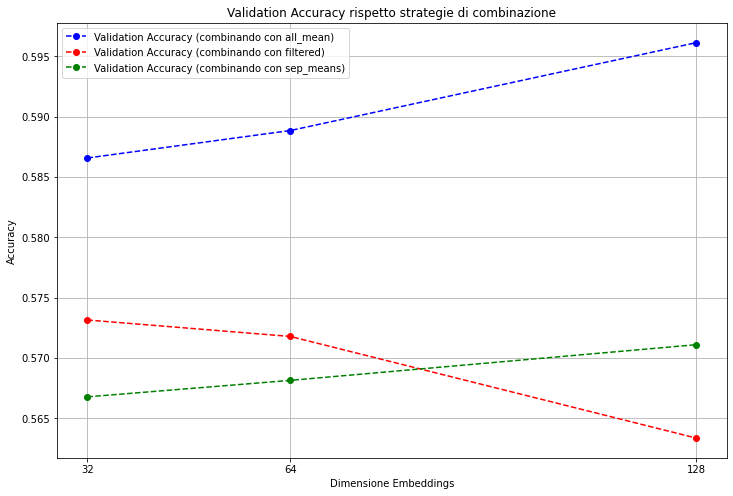

In [66]:
# Trova i risultati per ogni rappresentazione
val_accuracies = {"all_mean": [], "filtered": [], "sep_means": []}
test_accuracies = {"all_mean": [], "filtered": [], "sep_means": []}
embs_sizes = sorted(list(set(result["embedding_dim"] for result in results)))

# Calcola la media delle accuratezze per ciascuna dimensione di embedding
for mode in ["all_mean", "filtered", "sep_means"]:
    val_acc_per_dim = {dim: [] for dim in embs_sizes}
    test_acc_per_dim = {dim: [] for dim in embs_sizes}
    
    for result in results:
        if result["mode"] == mode:
            dim = result["embedding_dim"]
            val_acc_per_dim[dim].append(result["val_acc"])
            test_acc_per_dim[dim].append(result["test_acc"])
    
    # Calcola la media
    val_accuracies[mode] = [np.mean(val_acc_per_dim[dim]) for dim in embs_sizes]
    test_accuracies[mode] = [np.mean(test_acc_per_dim[dim]) for dim in embs_sizes]

# Colori per ogni rappresentazione
colors = {"all_mean": "blue", "filtered": "red", "sep_means": "green"}

# Grafico delle accuracy per il best model
plt.figure(figsize=(12, 8))

for mode in ["all_mean", "filtered", "sep_means"]:
    plt.plot(
        embs_sizes,
        val_accuracies[mode],
        label=f"Validation Accuracy (combinando con {mode})",
        color=colors[mode],
        linestyle="--",
        marker="o"
    )

plt.title("Validation Accuracy rispetto strategie di combinazione")
plt.xlabel("Dimensione Embeddings")
plt.ylabel("Accuracy")
plt.xticks(embs_sizes)
plt.legend()
plt.grid(True)
plt.show()
